In [1]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import pandas as pd
import geopandas as gpd
from IPython.display import IFrame
import pathlib
import datetime as dt

%matplotlib inline

# turn response caching on and turn on logging to your terminal window
ox.config(log_console=True, use_cache=True)

ox.__version__

'1.0.1'

# Network download and projection

In the following, we define a function to download the graph for the city of Mérida, Yucatán, or, if already present, load it as an NetworkX graph object.

In [2]:
places = [{'county' : 'Merida',
           'state' : 'Yucatan',
           'country' : 'Mexico'},
          {'county' : 'Kanasin',
           'state' : 'Yucatan',
           'country' : 'Mexico'}]

def get_roads_osmnx(places, update=False, proj=False):

    dirpath = pathlib.Path('./networks/')
    filepath = dirpath/'merida-kanasin-road.graphml'
    logpath = dirpath/'log'
                                    
    if filepath.exists() and not update:
        G = ox.load_graphml(filepath)
    else:
        # get drivable public streets network, aka road network, without service roads,
        # e.g. private, parking lots, etc.
        # use retain_all if you want to keep all disconnected subgraphs (e.g. when your places aren't adjacent)
        # TODO: It would be nice to setup up a polygon for the city and its surrounding areas, to be sure
        # exactly the location.
        G = ox.graph_from_place(places, network_type='drive')
        ox.save_graphml(G, filepath=filepath, gephi=False)
        
    if proj:
        G = ox.project_graph(G)
    
    print(f"Graph created at: {G.graph['created_date']}")
    return G, *ox.graph_to_gdfs(G)
        
G, nodes, edges = get_roads_osmnx(places, update=False)
G_proj, nodes_proj, edges_proj = get_roads_osmnx(places, update=False, proj=True)

Graph created at: 2021-02-11 09:51:33
Graph created at: 2021-02-11 09:51:33


In [49]:
G.graph

{'created_date': '2021-02-11 09:51:33',
 'created_with': 'OSMnx 1.0.1',
 'crs': 'epsg:4326',
 'simplified': True}

In [53]:
G_proj.graph

{'created_date': '2021-02-11 09:51:33',
 'created_with': 'OSMnx 1.0.1',
 'crs': <Projected CRS: +proj=utm +zone=16 +ellps=WGS84 +datum=WGS84 +unit ...>
 Name: unknown
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - undefined
 Coordinate Operation:
 - name: UTM zone 16N
 - method: Transverse Mercator
 Datum: World Geodetic System 1984
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 'simplified': True}

The original graph is a lat-long graph, meaning units are in degrees. A useful projection is UTM, which handles units in meters. For more info read: https://docs.qgis.org/3.16/en/docs/gentle_gis_introduction/coordinate_reference_systems.html. The projected stores orignal lat-long coordinates as attributes for nodes.

Given that some projections are more suited for different applications, we now keep both graphs. For example, the UTM projection is best for areas, while maybe the lat-long is best for calculations involving angles (maybe? TODO, confirm). TODO: Find more info on this, meybe is enough to keep UTM, since it uses meters, and we are more used to them.

If working with latlong, the haversine distance should be used, in UTM euclidian distance is appropriate. omsnx docs reccomend using projected coordinates for most distance based calculations. Bearing calculations require lat-long coords.

It is also useful to obtein geopandas dataframes for nodes and edges separately.

In [50]:
nodes.head()

,y,x,street_count,highway,geometry
osmid,,,,,
286974477,20.900216,-89.509268,4,NaN,POINT (-89.50927 20.90022)
286974740,20.905018,-89.526717,3,NaN,POINT (-89.52672 20.90502)
286974743,20.924688,-89.560150,4,NaN,POINT (-89.56015 20.92469)
287020194,20.896659,-89.647519,3,NaN,POINT (-89.64752 20.89666)
287020195,20.908412,-89.625401,3,NaN,POINT (-89.62540 20.90841)


In [43]:
nodes_proj.head()

,y,x,street_count,lon,lat,highway,geometry
osmid,,,,,,,
286974477,2.313144e+06,238979.238129,4,-89.509268,20.900216,NaN,POINT (238979.238 2313144.246)
5443055966,2.312975e+06,238942.058329,3,-89.509599,20.898686,NaN,POINT (238942.058 2312975.392)
2198242153,2.313560e+06,238272.588602,3,-89.516119,20.903869,NaN,POINT (238272.589 2313559.995)
286974740,2.313705e+06,237171.587836,3,-89.526717,20.905018,NaN,POINT (237171.588 2313704.613)
2198242162,2.313341e+06,237532.107574,3,-89.523199,20.901791,NaN,POINT (237532.108 2313341.400)


In [44]:
edges.head()

osmid  oneway      ref      highway  \
u         v          key                                                        
286974477 5443055966 0                 42683673    True  MEX 188      primary   
          2198242153 0                209633188   False      NaN  residential   
286974740 2198242162 0                 27528695   False      NaN     tertiary   
          5011841588 0    [786072812, 42683694]   False      NaN     tertiary   
          1889020903 0                 42683694   False      NaN     tertiary   

                         maxspeed    length  \
u         v          key                      
286974477 5443055966 0         90   173.530   
          2198242153 0        NaN   829.226   
286974740 2198242162 0        NaN   518.353   
          5011841588 0        NaN  1685.374   
          1889020903 0        NaN   973.604   

                                                                   geometry  \
u         v          key                                                      
286974477 5443055966 0    LINESTRING (-89.50927 20.90022, -89.50960 20.8...   
          2198242153 0    LINESTRING (-89.50927 20.90022, -89.50946 20.9...   
286974740 2198242162 0    LINESTRING (-89.52672 20.90502, -89.52500 20.9...   
          5011841588 0    LINESTRING (-89.52672 20.90502, -89.52771 20.9...   
          1889020903 0    LINESTRING (-89.52672 20.90502, -89.52636 20.9...   

                              name lanes bridge junction tunnel access width  
u         v          key                                                      
286974477 5443055966 0         NaN   NaN    NaN      NaN    NaN    NaN   NaN  
          2198242153 0         NaN   NaN    NaN      NaN    NaN    NaN   NaN  
286974740 2198242162 0         NaN   NaN    NaN      NaN    NaN    NaN   NaN  
          5011841588 0    Calle 21   NaN    NaN      NaN    NaN    NaN   NaN  
          1889020903 0         NaN   NaN    NaN      NaN    NaN    NaN   NaN

In [45]:
edges_proj.head()

osmid  oneway      ref  \
u          v          key                                            
286974477  5443055966 0                  42683673    True  MEX 188   
           2198242153 0                 209633188   False      NaN   
5443055966 5443055948 0                  42683673    True  MEX 188   
           5443055955 0                 565071113    True      NaN   
2198242153 2198242137 0    [684178840, 209633186]   False      NaN   

                                highway maxspeed   length  \
u          v          key                                   
286974477  5443055966 0         primary       90  173.530   
           2198242153 0     residential      NaN  829.226   
5443055966 5443055948 0         primary       90  134.567   
           5443055955 0    primary_link      NaN   14.896   
2198242153 2198242137 0     residential      NaN  735.164   

                                                                    geometry  \
u          v          key                                                      
286974477  5443055966 0    LINESTRING (238979.238 2313144.246, 238942.058...   
           2198242153 0    LINESTRING (238979.238 2313144.246, 238959.329...   
5443055966 5443055948 0    LINESTRING (238942.058 2312975.392, 238910.830...   
           5443055955 0    LINESTRING (238942.058 2312975.392, 238946.166...   
2198242153 2198242137 0    LINESTRING (238272.589 2313559.995, 238248.432...   

                          name lanes bridge junction tunnel access width  
u          v          key                                                 
286974477  5443055966 0    NaN   NaN    NaN      NaN    NaN    NaN   NaN  
           2198242153 0    NaN   NaN    NaN      NaN    NaN    NaN   NaN  
5443055966 5443055948 0    NaN   NaN    NaN      NaN    NaN    NaN   NaN  
           5443055955 0    NaN   NaN    NaN      NaN    NaN    NaN   NaN  
2198242153 2198242137 0    NaN   NaN    NaN      NaN    NaN    NaN   NaN

## Networkit conversion for fast algorithms

In [27]:
import networkit as nk

# Convert a networkx graph into a networkit graph, 
# properties are lost, only nodes and edges are preserved (TODO:verify)

Gkit = nk.nxadapter.nx2nk(G_proj, weightAttr=None)
print(Gkit.numberOfNodes(), Gkit.numberOfEdges())

38450 102944


Nodes are simply integer indices, and edges are pairs of such indices.

In [31]:
i = 0
for u in Gkit.iterNodes():
    print(u)
    i += 1
    if i > 4: break

0
1
2
3
4


In [33]:
i = 0
for u, v in Gkit.iterEdges():
    if i > 5:
        print('...')
        break
    print(u, v)
    i += 1

0 1
0 2
1 32835
1 32837
2 1944
2 23359
...


For kit analysis to be useful, we need to be able to map them back to the original nodes. For this we explicitly store the map used by Networkit internally.

In [39]:
# Get mapping from node ids in nxG to node ids in G
idmap = dict((id, u) for (id, u) in zip(G_proj.nodes(), range(G_proj.number_of_nodes())))
# TODO: Add it to the nodes dataframe.

# Some general consideration on the data structures, graph and dataframes

In [22]:
type(G)

networkx.classes.multidigraph.MultiDiGraph

In [25]:
print(f"The road network has {G.number_of_edges()} edges and {G.number_of_nodes()} nodes")

The road network has 102944 edges and 38450 nodes


Nodes are street intersections, with y and x coordinates and the number of streets intersecting the node, and other potential attributes. 

Nodes are indexed by an integer value.

In [27]:
G.nodes[287026838]

{'y': 21.0118318, 'x': -89.6135586, 'street_count': 3}

In [28]:
G_proj.nodes[287026838]

{'y': 2325679.8863945464,
 'x': 228326.89813988266,
 'street_count': 3,
 'lon': -89.6135586,
 'lat': 21.0118318}

We now list all attributes present in the graph nodes:

In [29]:
from itertools import chain

set(chain.from_iterable(d.keys() for *_, d in G_proj.nodes(data=True)))

{'highway', 'lat', 'lon', 'street_count', 'x', 'y'}

We have a highway attribute, how many nodes have this attribute?

In [32]:
h_count = 0
for node, attr in G_proj.nodes.items():
    if 'highway' in attr.keys():
        h_count += 1
h_count

878

What are its possible values?

In [31]:
set(nx.get_node_attributes(G, 'highway').values())

{'crossing',
 'mini_roundabout',
 'passing_place',
 'traffic_signals',
 'turning_circle',
 'turning_loop'}

Edges are roads and are indexed by their starting and ending nodes, and a zero(TODO; what is that zero?). They are tuple objects.

OK, the zero is the edge key, since in a multigraph we can have potentially more than one edge between a pair of nodes, each edge is identofied by a key.

TODO: Determine is this is indeed a multigraph. Are more than one edge for any pair of nodes? Use the key.

In [34]:
for u in G_proj.nodes():
    for neighbor in G_proj.neighbors(u):
        if G_proj.number_of_edges(u, neighbor) > 2:
            print (u,neighbor)

2028847780 2028847782
2028847782 2028847780


In [37]:
G.edges[2028847780, 2028847782, 0]

{'osmid': 443843678,
 'name': 'Calle 32',
 'highway': 'residential',
 'oneway': False,
 'length': 54.026}

In [38]:
G_proj.edges[2028847780, 2028847782, 0]

{'osmid': 443843678,
 'oneway': False,
 'highway': 'residential',
 'length': 54.026,
 'geometry': <shapely.geometry.linestring.LineString at 0x7fc29833f820>,
 'name': 'Calle 32'}

In [39]:
G_proj.edges[2028847782, 2028847780, 1]

{'osmid': [369316954, 369316955, 369316951],
 'oneway': False,
 'highway': 'residential',
 'length': 190.781,
 'geometry': <shapely.geometry.linestring.LineString at 0x7fc29833f940>,
 'name': ['Calle 39-A', 'Calle 30', 'Calle 39B-1']}

We now list all available attributes.

In [40]:
set(chain.from_iterable(d.keys() for *_, d in G_proj.edges(data=True)))

{'access',
 'bridge',
 'geometry',
 'highway',
 'junction',
 'lanes',
 'length',
 'maxspeed',
 'name',
 'oneway',
 'osmid',
 'ref',
 'tunnel',
 'width'}

TODO: Explore what are each of these, their possible values and units, the projection in case of the geometry, and how many nodes posses each attribute (or fraction of total nodes) to give an idea of how useful they are.

TODO: Visualize tha graph with all attributes either printed or as an overlay.

Folium is too slow, and the html is too large (100 megs), maybe there are some tricks to increase performance. And we haven't even added the nodes.

Let's try some static maps from osmnx directly, and using geopandas.

# Basic Network Stats

omsnx already provides quite an array of useful metrics that can be automatically calculated.

## Cover area

In [4]:
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m # Squared meters? What is the oficial value?

991812704.1111697

In [5]:
%%time
basic_stats = ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')
basic_stats.keys()

CPU times: user 46.8 s, sys: 179 ms, total: 47 s
Wall time: 47 s


dict_keys(['n', 'm', 'k_avg', 'intersection_count', 'streets_per_node_avg', 'streets_per_node_counts', 'streets_per_node_proportion', 'edge_length_total', 'edge_length_avg', 'street_length_total', 'street_length_avg', 'street_segments_count', 'node_density_km', 'intersection_density_km', 'edge_density_km', 'street_density_km', 'circuity_avg', 'self_loop_proportion', 'clean_intersection_count', 'clean_intersection_density_km'])

In [11]:
%%time
# Takes a lot of time, save output to disk, recompute with care.

# Bare stats are not computationally expensive
ext_stats_bare = ox.stats.extended_stats(G_proj, connectivity=False, anc=False, ecc=False, bc=False, cc=False)
ext_stats_bare.keys()

CPU times: user 9.08 s, sys: 100 ms, total: 9.18 s
Wall time: 9.18 s


dict_keys(['avg_neighbor_degree', 'avg_neighbor_degree_avg', 'avg_weighted_neighbor_degree', 'avg_weighted_neighbor_degree_avg', 'degree_centrality', 'degree_centrality_avg', 'clustering_coefficient', 'clustering_coefficient_avg', 'clustering_coefficient_weighted', 'clustering_coefficient_weighted_avg', 'pagerank', 'pagerank_max_node', 'pagerank_max', 'pagerank_min_node', 'pagerank_min'])

Since it ha proven competionally infeasible to get extenddn stats for the complete graph, we try decomposing the orginal fucntion and calculate some stats directly, trying to identify the expensive routines.

In [19]:
# get largest strongly connected component, for those metrics that require
# strongly connected graphs
Gs = ox.utils_graph.get_largest_component(G_proj, strongly=True)

In [20]:
print(f"The largest strongly connected component has {Gs.number_of_edges()/G_proj.number_of_edges()} edges and {Gs.number_of_nodes()/G_proj.number_of_nodes()} nodes")

The largest strongly connected component has 0.9989897419956482 edges and 0.9982054616384916 nodes


Thats weird, it must mean we cannot reach some part of the city from some nodes (TODO: verify)

In [21]:
# Not memory expensive, but time consuming.
# IDEA: find the connectivity of each individual neighborhood with the rest of the city (markov blanket?) Much be much quicker.
node_connectivity = nx.node_connectivity(Gs)

In [22]:
node_connectivity #Appky mincut to udersttan this

1

In [23]:
edge_connectivity = nx.edge_connectivity(Gs)

In [24]:
edge_connectivity

1

This single edge/node ake this metric not very useful. It maybe worth repeatting with city instead of county, or just merida inside Periferico. On the toher hand, it would be interesting to know the conectivity of complete neighborhoods, and probably faster to calculate.

In [25]:
node_connectivity_avg = nx.average_node_connectivity(G_proj)
node_connectivity_avg

KeyboardInterrupt: 

There are som functions in networkX that apprixmate these measures providing a lower bound, which could prove useful. TODO: explore the fesability of those functions.

# Visualization

# Administrative boundaries from OSM

There is supposly a way to download administrative boundaries from OSM. It seems data for Mérida is very poor, only 3 neighborhoods present, what a shame.

Seems AGEBS are our best bets.

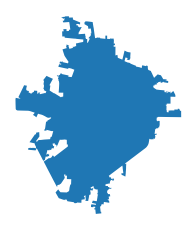

In [46]:
nbrhd = ox.geocode_to_gdf('Mérida, Yucatán')
ax = ox.project_gdf(nbrhd).plot()
ax.axis('off');

## Importing shapefiles containing polygons of Colonias de Mexico using GeoPandas (http://datamx.io/dataset/colonias-mexico)

In order to perform some analysis involving how data metrics change with scale, we import the neiborhoods of the city as shapefiles to create a subgraph for each different neigborhood.

In [5]:
#read the files from the Colonias folder using geopandas just as if we were using only pandas
colonias = gpd.read_file('input_data/coloniasmexico/Colonias/')

#query to filter only the colonias from Merida municipality of Yucatan state
colonias_yucatan_merida = colonias[(colonias['ST_NAME']=='YUCATAN') & (colonias['MUN_NAME'] == 'MÉRIDA')]

#query to filter only the colonias from Kanasin municipality of Yucatan state
colonias_yucatan_kanasin = colonias[(colonias['ST_NAME']=='YUCATAN') & (colonias['MUN_NAME'] == 'KANASÍN')]

colonias_yucatan_merida_kanasin = pd.concat([colonias_yucatan_merida, colonias_yucatan_kanasin])

colonias_yucatan_merida_kanasin.head(3)

,OBJECTID,POSTALCODE,ST_NAME,MUN_NAME,SETT_NAME,SETT_TYPE,AREA,Shape_Leng,Shape_Area,geometry
56515,56516,97000,YUCATAN,MÉRIDA,BARRIO SAN SEBASTIAN,FRACCIONAMIENTO,724836804.0,0.028660,0.000038,"POLYGON Z ((-89.63250 20.96072 0.00000, -89.63..."
56516,56517,97000,YUCATAN,MÉRIDA,BARRIO SANTA ANA,FRACCIONAMIENTO,724836804.0,0.031112,0.000051,"POLYGON Z ((-89.62424 20.97568 0.00000, -89.62..."
56517,56518,97000,YUCATAN,MÉRIDA,BARRIO SANTIAGO,FRACCIONAMIENTO,724836804.0,0.023338,0.000034,"POLYGON Z ((-89.62914 20.96978 0.00000, -89.62..."


The reference system used in the neiborhoods shpefile is WGS 84 (explain a little about this). It seems to me, it is not too important, as nodes are geolocated, but may be important when we define out own polygons to query subregions.

In [41]:
#view info of the Coordinate Reference System (CRS)
colonias_yucatan_merida_kanasin.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

TODO: Display a visualization of the colonias and the road network.

TODO: Create or obtain polygons for the main zones of the city, as in http://isla.merida.gob.mx/serviciosinternet/ordenamientoterritorial/docs/estrategico/E_01_ZONAS__PRIMARIAS.jpg.
O for the 5 main zones, north, south, east, west and center.

Also consider: http://isla.merida.gob.mx/serviciosinternet/ordenamientoterritorial/paginas/pmdu.phpx
Check what kind of data can we obtain from there.

## Creating vector of measures for each Colonia as subgraph

In [36]:
#extract nodes as a geodataframe
nodes = ox.graph_to_gdfs(G, edges=False)

In [37]:
nodes.head()

,y,x,street_count,highway,geometry
osmid,,,,,
286974477,20.900216,-89.509268,4,NaN,POINT (-89.50927 20.90022)
286974740,20.905018,-89.526717,3,NaN,POINT (-89.52672 20.90502)
286974743,20.924688,-89.560150,4,NaN,POINT (-89.56015 20.92469)
287020194,20.896659,-89.647519,3,NaN,POINT (-89.64752 20.89666)
287020195,20.908412,-89.625401,3,NaN,POINT (-89.62540 20.90841)


In [42]:
nodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [38]:
#extract edges as a geodataframe
edges = ox.graph_to_gdfs(G, nodes=False)

In [39]:
edges.head()

osmid  oneway      ref      highway  \
u         v          key                                                        
286974477 5443055966 0                 42683673    True  MEX 188      primary   
          2198242153 0                209633188   False      NaN  residential   
286974740 2198242162 0                 27528695   False      NaN     tertiary   
          5011841588 0    [786072812, 42683694]   False      NaN     tertiary   
          1889020903 0                 42683694   False      NaN     tertiary   

                         maxspeed    length  \
u         v          key                      
286974477 5443055966 0         90   173.530   
          2198242153 0        NaN   829.226   
286974740 2198242162 0        NaN   518.353   
          5011841588 0        NaN  1679.496   
          1889020903 0        NaN   973.604   

                                                                   geometry  \
u         v          key                                                      
286974477 5443055966 0    LINESTRING (-89.50927 20.90022, -89.50960 20.8...   
          2198242153 0    LINESTRING (-89.50927 20.90022, -89.50946 20.9...   
286974740 2198242162 0    LINESTRING (-89.52672 20.90502, -89.52500 20.9...   
          5011841588 0    LINESTRING (-89.52672 20.90502, -89.52771 20.9...   
          1889020903 0    LINESTRING (-89.52672 20.90502, -89.52636 20.9...   

                              name lanes bridge junction tunnel width access  
u         v          key                                                      
286974477 5443055966 0         NaN   NaN    NaN      NaN    NaN   NaN    NaN  
          2198242153 0         NaN   NaN    NaN      NaN    NaN   NaN    NaN  
286974740 2198242162 0         NaN   NaN    NaN      NaN    NaN   NaN    NaN  
          5011841588 0    Calle 21   NaN    NaN      NaN    NaN   NaN    NaN  
          1889020903 0         NaN   NaN    NaN      NaN    NaN   NaN    NaN

In [43]:
edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Measures

#### Basic stats:

<ul>
    <li>n = number of nodes in the graph</li>
    <li>m = number of edges in the graph </li>
    <li>k_avg = average node degree of the graph </li>
    <li> intersection_count = number of intersections in graph, that is,
    nodes with >1 physical street connected to them </li>
    <li>streets_per_node_avg = how many physical streets (edges in the
    undirected representation of the graph) connect to each node (ie, intersection or dead-end) on average (mean) </li>
    <li>streets_per_node_counts = dict with keys of number of physical
    streets connecting to a node, and values of number of nodes with this count </li>
    <li>streets_per_node_proportion = dict, same as previous, but as a
    proportion of the total, rather than counts </li>
    <li>edge_length_total = sum of all edge lengths in graph, in meters </li>
    <li>edge_length_avg = mean edge length in the graph, in meters </li>
    <li>street_length_total = sum of all edges in the undirected
    representation of the graph </li>
    <li>street_length_avg = mean edge length in the undirected
    representation of the graph, in meters </li>
    <li>street_segments_count = number of edges in the undirected
    representation of the graph</li>
    <li>node_density_km = n divided by area in square kilometers</li>
    <li>intersection_density_km = intersection_count divided by area in
    square kilometers</li>
    <li>edge_density_km = edge_length_total divided by area in square
    kilometers</li>
    <li>street_density_km = street_length_total divided by area in square
    kilometers</li>
    <li>circuity_avg = edge_length_total divided by the sum of the great
    circle distances between the nodes of each edge</li>
    <li>self_loop_proportion = proportion of edges that have a single node
    as its endpoints (ie, the edge links nodes u and v, and u==v)</li>
    <li>clean_intersection_count = number of intersections in street
    network, merging complex ones into single points</li>
    <li>clean_intersection_density_km = clean_intersection_count divided
    by area in square kilometers</li>
</ul>

#### Extended stats:

<ul>
    <li>avg_neighbor_degree = Mean degree of nodes in the neighborhood of each node</li>
    <li>avg_neighbor_degree_avg = Mean of all average neighborhood degrees in network</li>
    <li>avg_weighted_neighbor_degree = Mean degree of nodes in the neighborhood of each node, weighted by edge length</li>
    <li>avg_weighted_neighbor_degree_avg = Mean of all weighted average neighborhood degrees in network</li>
    <li>degree_centrality = Fraction of nodes that each node is connected to</li>
    <li>degree_centrality_avg = Mean of all degree centralities in network</li>
    <li>clustering_coefficient = Extent to which node's neighborhood forms a complete graph</li>
    <li>clustering_coefficient_avg</li>
    <li>clustering_coefficient_weighted = Extent to which node's neighborhood forms a complete graph, weighted by edge length</li>
    <li>clustering_coefficient_weighted_avg = Mean of weighted clustering coefficients of all nodes in network</li>
    <li>pagerank = Ranking of nodes based on structure of incoming edges</li>
    <li>pagerank_max_node = Node with the maximum PageRank</li>
    <li>pagerank_max = Highest PageRank value of any node in the graph</li>
    <li>pagerank_min_node = Node with the minimum PageRank</li>
    <li>pagerank_min = Lowest PageRank value of any node in the graph</li>
    <li>node_connectivity = Minimum number of nodes that must be removed to disconnect network</li>
    <li>node_connectivity_avg = Expected number of nodes that must be removed to	disconnect randomly selected pair of non-adjacent nodes</li>
    <li>edge_connectivity = Minimum number of edges that must be removed to disconnect network</li>
    <li>eccentricity = For each node, the maximum distance from it to all other nodes, weighted by length</li>
    <li>diameter = Maximum eccentricity of any node in network</li>
    <li>radius = Minimum eccentricity of any node in network</li>
    <li>center = Set of all nodes whose eccentricity equals the radius</li>
    <li>periphery = Set of all nodes whose eccentricity equals the diameter</li>
    <li>closeness_centrality = For each node, the reciprocal of the sum of the distance from the node to all other nodes in the graph, weighted by length</li>
    <li>closeness_centrality_avg = Mean of all the closeness centralities of all the nodes in network</li>
    <li>betweenness_centrality = For each node, the fraction of all shortest paths that pass through the node</li>
    <li>betweenness_centrality_avg = Mean of all the betweenness centralities of all the nodes in network</li>
</ul>

In [40]:
# for each colonia polygon, find intersecting nodes then induce subgraph
j = 0
subgraphs_colonias = [] #vector for storing subgraphs
stats = [] #vector for storing stats from osmnx
vec = [] #vector for storing stats both basic and extended; only the values
for i in range(colonias_yucatan_merida_kanasin.size):
    j = j+1
    if j == 10: #only the first 10 colonia; just for testing
        break
        
    #polygon = colonias_yucatan_merida.iloc[i].geometry
    #colonia_name = colonias_yucatan_merida.iloc[i].SETT_NAME
    #mun_name = colonias_yucatan_merida.iloc[i].MUN_NAME
    #ob_id = colonias_yucatan_merida.iloc[i].OBJECTID

    
    try: 
        #try/except for handling empty graphs; 
        #if the graph is empty, NetworkX raises an error and stops the loop;
        #this code ignores the empty graphs in the except statement
        intersecting_nodes = nodes[nodes.intersects(polygon)].index
        G_sub = G.subgraph(intersecting_nodes)
        subgraphs_colonias.append(G_sub)
        stat = ox.basic_stats(G_sub, 
                              area=None, #the land area of this study site, in square meters. must be greater than 0. if None, will skip all density-based metrics.
                              clean_intersects=False, #if True, calculate consolidated intersections count (and density, if area is provided) via consolidate_intersections function
                              circuity_dist='gc') #‘gc’ or ‘euclidean’, how to calculate straight-line distances for circuity measurement; use former for lat-lng networks and latter for projected networks
        extended_stat = ox.extended_stats(G_sub, 
                                          connectivity=False, #if True, calculate node and edge connectivity
                                          anc=False, #if True, calculate average node connectivity
                                          ecc=True, #calculate shortest paths, eccentricity, and topological metrics that use eccentricity
                                          bc=True, #calculate node betweenness centrality
                                          cc=True) #calculate node closeness centrality
        for key, value in extended_stat.items():
            stat[key] = value #insert the extended stats values
        vec = [stat[elem] for elem in stat if isinstance(stat[elem], dict) == False] #add only the values except the dict type
        stats.append(vec)
        #print(ob_id + ", " + colonia_name + ", " + mun_name)
        #fig, ax = ox.plot_graph(G_sub)
    except:
        pass